In [1]:
import pickle 
import pandas as pd 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, minmax_scale
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV 
from pprint import pprint
from keras.models import load_model
from tqdm import tqdm 

import collections 
import random 
import numpy as np 
import os 

# Raw Actual Values

In [ ]:
Save_File = "TensorflowAccuracySaves.pkl"

retrieved_data = None

with open(Save_File, "rb") as f:
    retrieved_data = pickle.load(f)

for model_key in retrieved_data:
    current_model = retrieved_data[model_key]
    for rbm_layer in current_model:
        current_iteration = current_model[rbm_layer]
        print(f"Model: {model_key}\tLayer: {rbm_layer}\tAcc: {current_iteration['accuracy']}")
    print("\n")


# Testing with Actual Data

In [2]:
FULL_DATA = False
LE = LabelEncoder()
WINDOW_LENGTH = 5


In [3]:
concatenated_data = pd.read_csv("Concatenated Data.csv")

if FULL_DATA:
    raw_dataset = concatenated_data[["tempmax", "tempmin", "temp", "feelslikemax", "feelslikemin", "feelslike", "dew", "humidity", "windspeed", "sealevelpressure", "conditions"]]
else:
    raw_dataset = concatenated_data[["temp", "feelslike", "humidity", "windspeed", "sealevelpressure", "conditions"]]

raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])

t_arr = raw_dataset.copy().to_numpy()
X = []
y = []

for i in range(len(t_arr) - WINDOW_LENGTH):
    t_row = []
    for j in t_arr[i : i + WINDOW_LENGTH]:
        t_row.append(j[:-1])
    t_row = np.array(t_row).flatten()
    X.append(t_row)
    y.append(t_arr[i + WINDOW_LENGTH][-1])


X_orig = np.array(X, "float32")
X_append = np.array(X, "float32")
X_orig = minmax_scale(X_orig, feature_range = (0, 1))
X_append = minmax_scale(X_append, feature_range = (0, 1))


y_orig = np.array(y)
y_append = np.array(y)
counts = dict(collections.Counter(y))
max_count = max(counts.values())

C:\Users\Alaric\AppData\Local\Temp\ipykernel_3840\2654789865.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
C:\Users\Alaric\AppData\Local\Temp\ipykernel_3840\2654789865.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])


In [4]:
DATA_MULTIPLIER = 2
# Iterate through all of the counts of each items stored in the dictionary
# key = Weather Condition
# value = Occurence of Weather Condition
for key, value in counts.items():
    # Temporary Arrays
    curX = []
    curY = []
    
    # Get the indexes which is == current key (current weather condition)
    possibleChoices, = np.where(y_orig == key)

    # Create a list of copies from possible choices (Get from Orig since it is unmodified)
    print("Currently @ ", key, "Have", value, "values and", (max_count * DATA_MULTIPLIER - value), "missing values")
    for i in range((max_count * DATA_MULTIPLIER - value)):
        currentIndex = random.choice(possibleChoices)
        curX.append(X_orig[currentIndex])
        curY.append(y_orig[currentIndex])

    print("Temp Lengths", len(curX), len(curY))
    # Convert current X and Y to python lists
    # Extend the current X and Y with the temporary X and Y arrays (Which have copies of such weather condition)
    # Turn current X and Y to Np Arrays
    # Would not recursively do it, since the value and count is calculated before this
    tX = X_append.tolist()
    tY = y_append.tolist()

    tX.extend(curX)
    tY.extend(curY)
    
    X_append = np.array(tX)
    y_append = np.array(tY)        

# Original Values
X_train, X_orig_test, y_train, y_orig_test = train_test_split(X_orig, y_orig, test_size = 0.2)
X_orig_train, X_orig_valid, y_orig_train, y_orig_valid = train_test_split(X_train, y_train, test_size = 0.2)

# Appended Values
X_train, X_append_test, y_train, y_append_test = train_test_split(X_append, y_append, test_size = 0.2)
X_append_train, X_append_valid, y_append_train, y_append_valid = train_test_split(X_train, y_train, test_size = 0.2)


Currently @  1.0 Have 1682 values and 1682 missing values
Temp Lengths 1682 1682
Currently @  3.0 Have 1424 values and 1940 missing values
Temp Lengths 1940 1940
Currently @  0.0 Have 17 values and 3347 missing values
Temp Lengths 3347 3347
Currently @  2.0 Have 273 values and 3091 missing values
Temp Lengths 3091 3091


In [105]:
dict(collections.Counter(y_append))

{1.0: 3364, 3.0: 3364, 0.0: 3364, 2.0: 3364}

In [ ]:
Keras_Models_Path = "1 - KERAS MODELS"
SciKit_Models_Path = "2 - SCIKIT MODELS"
Keras_Model_Names = os.listdir(Keras_Models_Path)
SciKit_Model_Names = os.listdir(SciKit_Models_Path)

# Loop Through Keras Models

In [ ]:
# Actual Keras Results
Actual_TF_Results = {}

# Tensorflow Models

In [ ]:
# Original Only
for keras_model_name in tqdm(Keras_Model_Names):
    CurrentPredictor = load_model(os.path.join(Keras_Models_Path, keras_model_name))
    preds = CurrentPredictor.predict(X_orig_train)
    preds = np.argmax(preds, axis = 1)
    current_accuracy = accuracy_score(y_orig_train, preds)
    current_name = keras_model_name.replace(".keras", "").replace("_", " ")
    Actual_TF_Results[current_name] = current_accuracy
    # print(current_name, " : ", current_accuracy * 100)



In [ ]:
sorted(Actual_TF_Results.items(), key = lambda x : x[1], reverse = True)

In [ ]:
with open("ActualTensorflowAccuracy.pkl", "wb") as f:
    pickle.dump(Actual_TF_Results, f)

# SciKit Models

In [ ]:
Actual_SK_Results = {}

In [ ]:
for scikit_model_name in tqdm(SciKit_Model_Names):
    CurrentPredictor = None 
    with open(os.path.join(SciKit_Models_Path, scikit_model_name), "rb") as f:
        CurrentPredictor = pickle.load(f)

    preds = CurrentPredictor.predict(X_orig_train)
    current_accuracy = accuracy_score(y_orig_train, preds)
    current_name = scikit_model_name.replace(".pkl", "").replace("_", " ")

    Actual_SK_Results[current_name] = current_accuracy
    # print(current_name, " : ", current_accuracy * 100)


In [ ]:
sorted(Actual_SK_Results.items(), key = lambda x : x[1], reverse = True)

In [ ]:
with open("ActualSciKitAccuracy.pkl", "wb") as f:
    pickle.dump(Actual_SK_Results, f)

# Try and Increase Accuracy through ReAugment

In [ ]:
# counts = dict(collections.Counter(y))

In [106]:
# Goal - Augment Accuracy
CurrentPredictor = None 
with open(os.path.join(SciKit_Models_Path, "RANDOM FOREST_0_Layers.pkl"), "rb") as f:
    CurrentPredictor = pickle.load(f)

preds = CurrentPredictor.predict(X_append_train)
accuracy_score(y_append_train, preds)

0.9556381372662873

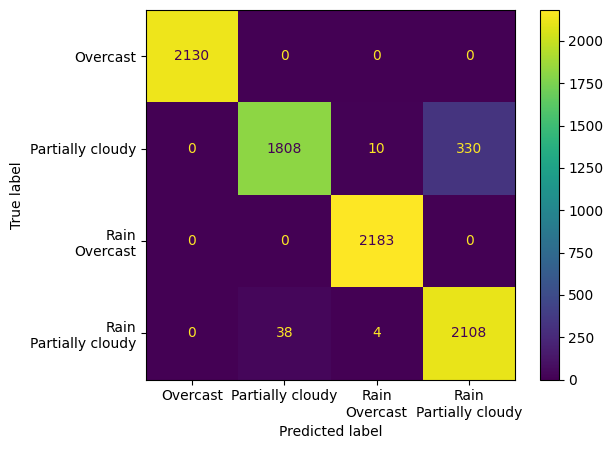

In [107]:
ConfusionMatrixDisplay(confusion_matrix(y_append_train, preds), display_labels = LE.classes_).plot()

In [108]:
# Goal - Augment Accuracy
CurrentPredictor = None 
with open(os.path.join(SciKit_Models_Path, "RANDOM FOREST_0_Layers.pkl"), "rb") as f:
    CurrentPredictor = pickle.load(f)

preds = CurrentPredictor.predict(X_orig_train)
accuracy_score(y_orig_train, preds)

0.9148250460405156

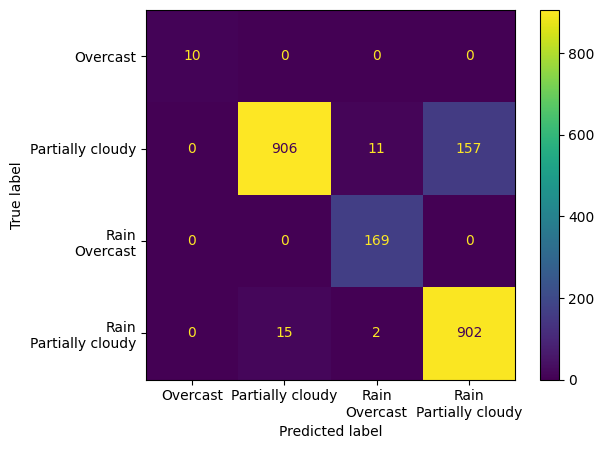

In [109]:
ConfusionMatrixDisplay(confusion_matrix(y_orig_train, preds), display_labels = LE.classes_).plot()

In [110]:
dict(collections.Counter(y_orig))

{1.0: 1682, 3.0: 1424, 0.0: 17, 2.0: 273}

In [111]:
dict(collections.Counter(y_append))

{1.0: 3364, 3.0: 3364, 0.0: 3364, 2.0: 3364}

In [113]:
# max(dict(collections.Counter(y_orig)).values())

rel_or = {}
for x in counts:
    rel_or[x] = counts[x] / max_count

In [114]:
rel_or

{1.0: 1.0,
 3.0: 0.8466111771700356,
 0.0: 0.010107015457788348,
 2.0: 0.16230677764565993}

In [ ]:
# Repeat Until Target Length is achieved
# Loop Through Augment, and Remove Random Samples
# Testing Evaluate again 